# Konvolutivni slojevi verzija 1

In [18]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import torch

Lokacija dataset-a

In [19]:
dataset_path = "../data_set/casting_data/casting_data"
classes = ["ok_front", "def_front"]

Inicijalizacija lista za cuvanje podataka


In [20]:
data = []
labels = []

Ucitavanje slika kroz klase


In [21]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "train", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        img = cv2.resize(img, (128, 128))  # Resize to 128x128
        data.append(img)
        labels.append(classes.index(class_name))

Konvertovanje listi u numpy


In [22]:
data = np.array(data) / 255.0  # Normalize pixel values
data = np.expand_dims(data, axis=-1)
labels = np.array(labels)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


ImageDataGenerator za data augmentation


In [24]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

CNN model sa konvolutivnim slojevima

In [25]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax')
])

/home/teki/Documents/sd3/.master/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1723472326.343735    4546 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 16:18:46.379792: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libr

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [28]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val),
                    epochs=50, callbacks=[early_stopping])


Epoch 1/50


/home/teki/Documents/sd3/.master/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 212ms/step - accuracy: 0.5571 - loss: 0.7830 - val_accuracy: 0.5614 - val_loss: 0.6835
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 212ms/step - accuracy: 0.5570 - loss: 0.6843 - val_accuracy: 0.5614 - val_loss: 0.6856
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.5701 - loss: 0.6826 - val_accuracy: 0.5614 - val_loss: 0.6562
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - accuracy: 0.6166 - loss: 0.6482 - val_accuracy: 0.6948 - val_loss: 0.5654
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 214ms/step - accuracy: 0.7247 - loss: 0.5640 - val_accuracy: 0.7694 - val_loss: 0.5207
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 214ms/step - accuracy: 0.7990 - loss: 0.4587 - val_accuracy: 0.7717 - val_loss: 0.4863
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 37s 219ms/step - accuracy: 0.8609 - loss: 0.3553 - val_accuracy: 0.6971 - val_loss: 0.5891
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.8740 - loss: 0.3130 - val

In [29]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

Evaluacija modela na test skupu

In [30]:
test_data = []
test_labels = []

In [31]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "test", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        test_data.append(img)
        test_labels.append(classes.index(class_name))

test_data = np.array(test_data) / 255.0
test_data = np.expand_dims(test_data, axis=-1)
test_labels = np.array(test_labels)

In [32]:
# Model evaluation
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9510


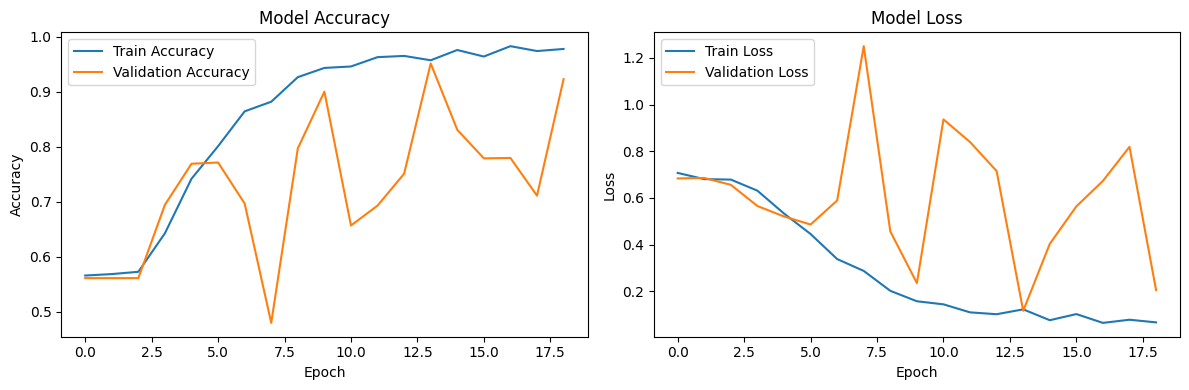

In [33]:
# Plotting training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Classification report

In [34]:
# Classification report
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes, target_names=classes)
print("Classification Report:")
print(report)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Classification Report:
              precision    recall  f1-score   support

    ok_front       0.89      0.99      0.94       262
   def_front       0.99      0.93      0.96       453

    accuracy                           0.95       715
   macro avg       0.94      0.96      0.95       715
weighted avg       0.96      0.95      0.95       715

